Un regroupement des caractéristiques obtenues est effectué sur une collection d'images définie par (n1,n2).
La collection d'images utilisée est "aloi_red4_view" (72 images par object).
On va utiliser les caractéristiques de couleurs et de texture.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from Image_reading import *
from Color_descriptors import *
from Shape_descriptors import concatShapeFeatures
from Texture_descriptors import lbp
    
#   Parameters defintion:
n1=1 # First image (included)
n2=11 # Last image (excluded)
n_img=72 # number of images per object

color_space='hsv'
bins=[4,4,4]
n_colors=8
n_fft=64
hist_size_lbp=100

classes_true=[]
for i in range(0,n2-n1):
    classes_true=classes_true+[i]*n_img
classes_true=np.array(classes_true)

#     First, we regroup the images features in a single 2D-Array where each line is the feature vector of an image
X_all=[]
for i in range(n_img*(n2-n1)):
    X_all.append([])
for i in range(n2-n1):
    for j in range(n_img):
        X=read_image_2(i+n1,j)

        # *********************************************************
        # ********************Color_features***********************
        # *********************************************************
        # *********************Color_moments***********************
        moments_ftr=moments_calcul(X,color_space)
        X_all[n_img*i+j]=X_all[n_img*i+j]+[moments_ftr]
        # *********************Color_histogram*********************
        hist= color_histogram(X,color_space,bins)
        X_all[n_img*i+j]=X_all[n_img*i+j]+[hist]

        """
        # *********************************************************
        # ********************Shape_features***********************
        # *********************************************************
        shape_ftr=concatShapeFeatures(X,n_fft)
        X_all[n_img*i+j]=X_all[n_img*i+j]+[shape_ftr]
        """
        # *********************************************************
        # ********************Texture_features*********************
        # *********************************************************
        lbp_feature=lbp(X,hist_size_lbp)
        X_all[n_img*i+j]=X_all[n_img*i+j]+[lbp_feature]

        X_all[n_img*i+j]=np.concatenate(X_all[n_img*i+j])

X_all=np.array(X_all).astype(float)
print("Number of objects= "+ str(n2-n1))
print("Number of images= "+ str(X_all.shape[0]))
print("Number of features= "+ str(X_all.shape[1]))

# ************Visualization_before_clustering******************
X_norm = StandardScaler().fit_transform(X_all)
X_embedded = TSNE(n_components=2).fit_transform(X_norm)

plt.figure(figsize=(15,10))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes_true,s=5)
plt.title("Visualization of the true classes")
plt.show()

Number of objects= 10
Number of images= 720
Number of features= 179


<Figure size 1500x1000 with 1 Axes>

On enregistre la matrice des caractéristiques pour pouvoir l'utiliser plus rapidement.

In [8]:
X=np.hstack((X_norm,classes_true[:,np.newaxis]))
np.save("feature_matrix_1",X)

On va d'abord utiliser l'algorithme du clustering est le k-means  (implémenté à l'aide de la scikitlearn) avec une distance euclidienne.
Les résultats sont évalués à l'aide de métriques comme l'adjusted rand score.

**************Clustering_results*********************
Number of clusters= 10
adjusted_rand_score=0.73
homogeneity_score=0.85
completeness_score=0.92
v_measure_score=0.88
fowlkes_mallows_score=0.77


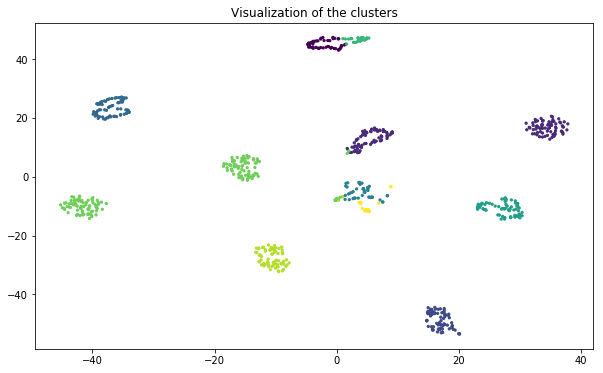

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from KMeansClustering import kmeans_clustering_sklearn
from sklearn.manifold import TSNE

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]
# ********************Clustering************************
n_clusters_=10 # number of objects
classes=kmeans_clustering_sklearn(X_norm,n_clusters_)

print("**************Clustering_results*********************")
print("Number of clusters= "+str(max(classes)+1))
print('adjusted_rand_score=%0.2f' % metrics.adjusted_rand_score(classes_true,classes))
print('homogeneity_score=%0.2f' % metrics.homogeneity_score(classes_true,classes))
print('completeness_score=%0.2f' % metrics.completeness_score(classes_true,classes))
print('v_measure_score=%0.2f' % metrics.v_measure_score(classes_true,classes))
print('fowlkes_mallows_score=%0.2f' % metrics.fowlkes_mallows_score(classes_true,classes))

# ************Visualization_after_clustering******************
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes,s=5)
plt.title("Visualization of the clusters")
plt.show()

On remarque qu'en combinant tous les descripteurs, on arrive bien séparer les images par objet (figure 1: Visualization of the true classes). Mais on remarque que l'algorithme k-means n'arrive pas à bien identifier les bons clusters (figure 2: Visualization of the clusters): On obtient un score de l'ordre de 75%.

On va utiliser d'autres défintions de distance. Comme l'outil sklearn n'offre pas la possibilité de modifier la distance, on va se servir d'une autre implémentation du kmeans qui permet de le faire manuellement. D'abord, on teste cette implémentation avec le même type de distance (euclidienne).

10 4.630592768969504 {0: 200.0, 1: 21.0, 2: 240.0, 3: 51.0, 4: 38.0, 5: 72.0, 6: 2.0, 7: 6.0, 8: 34.0, 9: 56.0}
**************Clustering_results*********************
Number of clusters= 10.0
adjusted_rand_score=0.45
homogeneity_score=0.67
completeness_score=0.86
v_measure_score=0.75
fowlkes_mallows_score=0.57


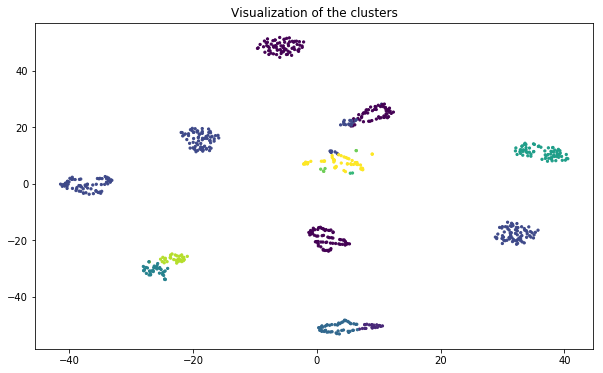

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from KMeansClustering import kmeans_pp
from sklearn.manifold import TSNE

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]

# ********************Clustering************************
# Distance choice: euclidean, ...
n_clusters_=10 # number of objects
classes=kmeans_pp(X_norm,n_clusters_,"euclidean")

print("**************Clustering_results*********************")
print("Number of clusters= "+str(max(classes)+1))
print('adjusted_rand_score=%0.2f' % metrics.adjusted_rand_score(classes_true,classes))
print('homogeneity_score=%0.2f' % metrics.homogeneity_score(classes_true,classes))
print('completeness_score=%0.2f' % metrics.completeness_score(classes_true,classes))
print('v_measure_score=%0.2f' % metrics.v_measure_score(classes_true,classes))
print('fowlkes_mallows_score=%0.2f' % metrics.fowlkes_mallows_score(classes_true,classes))

# ************Visualization_after_clustering******************
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes,s=5)
plt.title("Visualization of the clusters")
plt.show()

On remarque que l'implémentation de scikit-learn donne des meilleurs résultats que l'implémentation proposée. Pourtant, on va continuer à travailler avec la 2ème implémentation pour tester plusieurs types de distances.

euclidean
10 4.433410683641338 {0: 141.0, 1: 72.0, 2: 25.0, 3: 29.0, 4: 34.0, 5: 295.0, 6: 38.0, 7: 72.0, 8: 3.0, 9: 11.0}
manhattan
10 21.56350028008789 {0: 300.0, 1: 34.0, 2: 38.0, 3: 72.0, 4: 35.0, 5: 21.0, 6: 29.0, 7: 23.0, 8: 140.0, 9: 28.0}
chebyshev
10 2.036080795121999 {0: 73.0, 1: 70.0, 2: 140.0, 3: 2.0, 4: 3.0, 5: 12.0, 6: 72.0, 7: 50.0, 8: 72.0, 9: 226.0}
cosine
10 0.12989461095258864 {0: 72.0, 1: 34.0, 2: 38.0, 3: 138.0, 4: 23.0, 5: 72.0, 6: 72.0, 7: 49.0, 8: 155.0, 9: 67.0}
correlation
10 0.13686310924461786 {0: 66.0, 1: 72.0, 2: 72.0, 3: 34.0, 4: 154.0, 5: 72.0, 6: 138.0, 7: 2.0, 8: 38.0, 9: 72.0}


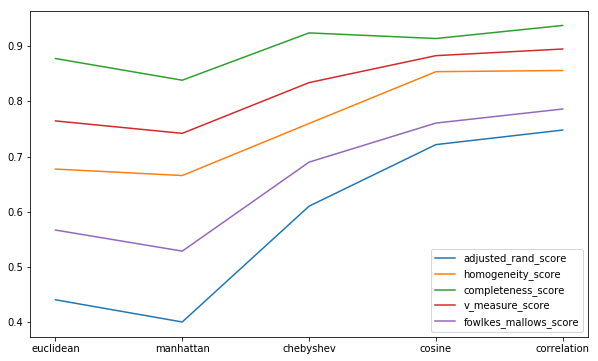

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from KMeansClustering import kmeans_pp

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]
# ********************Clustering************************
n_clusters_=10 # number of objects
distance=["euclidean","manhattan","chebyshev","cosine","correlation"]
adjusted_rand_score=[]
homogeneity_score=[]
completeness_score=[]
v_measure_score=[]
fowlkes_mallows_score=[]

for dist_type in distance:
    print(dist_type)
    classes=kmeans_pp(X_norm, n_clusters_, dist_type)
    adjusted_rand_score.append(metrics.adjusted_rand_score(classes_true,classes))
    homogeneity_score.append(metrics.homogeneity_score(classes_true,classes))
    completeness_score.append(metrics.completeness_score(classes_true,classes))
    v_measure_score.append(metrics.v_measure_score(classes_true,classes))
    fowlkes_mallows_score.append(metrics.fowlkes_mallows_score(classes_true,classes))
    
# ************Distance_comparison_kmeans******************
plt.figure(figsize=(10,6))
plt.plot(distance, adjusted_rand_score,label="adjusted_rand_score")
plt.plot(distance, homogeneity_score, label="homogeneity_score")
plt.plot(distance, completeness_score, label="completeness_score")
plt.plot(distance, v_measure_score, label="v_measure_score")
plt.plot(distance, fowlkes_mallows_score, label="fowlkes_mallows_score")
plt.legend()
plt.show()